In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
from torch.utils.data import Dataset
from PIL import Image
import torch.nn as nn

import warnings
warnings.filterwarnings("ignore")

import glob

from sklearn.model_selection import train_test_split

In [2]:
masks = glob.glob("/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/*/*_mask.png")

In [3]:
masks[1:4]

['/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (290)_mask.png',
 '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (430)_mask.png',
 '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (89)_mask.png']

In [4]:
images = [mask_images.replace("_mask", "") for mask_images in masks]

In [5]:
series = list(zip(images, masks))

In [6]:
series[:4]

[('/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (166).png',
  '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (166)_mask.png'),
 ('/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (290).png',
  '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (290)_mask.png'),
 ('/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (430).png',
  '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (430)_mask.png'),
 ('/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (89).png',
  '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (89)_mask.png')]

In [7]:
len(series)

780

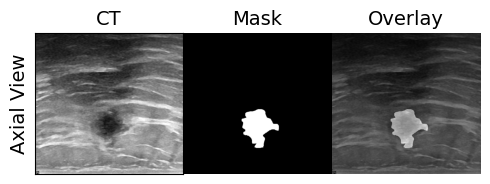

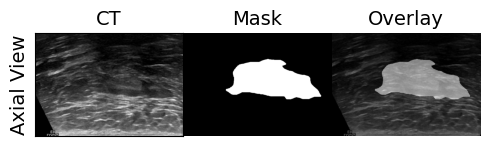

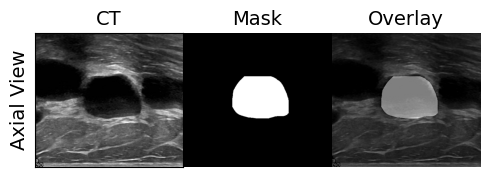

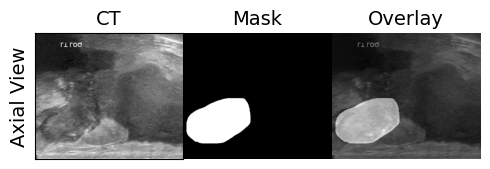

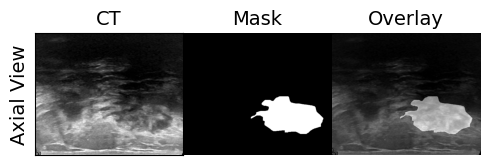

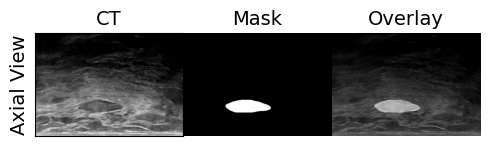

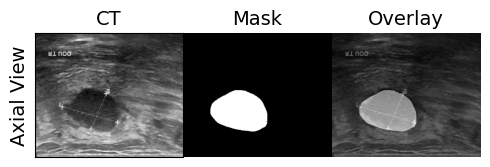

In [8]:
def plot_train_labels(image_mask):
    image = cv2.imread(image_mask[0])
    mask = cv2.imread(image_mask[1])
    
    _, axarr = plt.subplots(1, 3, figsize=(5, 5))
    
    axarr[0].imshow(np.squeeze(image), cmap='gray', origin='lower')
    axarr[0].set_ylabel('Axial View', fontsize=14)
    axarr[0].set_xticks([])
    axarr[0].set_yticks([])
    axarr[0].set_title('CT', fontsize=14)

    axarr[1].imshow(np.squeeze(mask), cmap='jet', origin='lower')
    axarr[1].axis('off')
    axarr[1].set_title('Mask', fontsize=14)

    axarr[2].imshow(np.squeeze(image), cmap='gray', alpha=1, origin='lower')
    axarr[2].imshow(np.squeeze(mask), cmap='jet', alpha=0.5, origin='lower')
    axarr[2].axis('off')
    axarr[2].set_title('Overlay', fontsize=14)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    
    
random_image = random.sample(range(750), 7)
for image in random_image:
    plot_train_labels(series[image])

In [9]:
dataset = pd.DataFrame(series, columns = ['image_path', 'mask_path'])
dataset

,image_path,mask_path
0,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...
1,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...
2,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...
3,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...
4,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...
...,...,...
775,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...
776,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...
777,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...
778,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...


In [10]:
train, test= train_test_split(dataset, test_size=0.25)

In [11]:
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

Train shape: (585, 2)
Test shape: (195, 2)


In [12]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class CustomImageMaskDataset(Dataset):
    np.random.seed(42)
    torch.manual_seed(42)
    def __init__(self, dataframe, image_transform = None):
        self.data = dataframe
        self.image_transform = image_transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image_path = self.data.iloc[idx]['image_path']
        mask_path = self.data.iloc[idx]['mask_path']
        image = Image.open(image_path).convert('L')
        mask = Image.open(mask_path).convert('L')
        
        if self.image_transform:
            image = self.image_transform(image)
            mask = self.image_transform(mask)
            
        return image, mask
    
image_size = 128
train_transforms = transforms.Compose([
    transforms.Resize([image_size, image_size]),
    transforms.ToTensor(),
])
val_transforms = transforms.Compose([
    transforms.Resize([image_size, image_size]),
    transforms.ToTensor(),
])


train_dataset = CustomImageMaskDataset(train, train_transforms)
test_dataset = CustomImageMaskDataset(test, val_transforms)

batch_size = 16
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [13]:
for batch in train_dataloader:
    # Assuming your dataset returns a tuple (inputs, targets)
    inputs, targets = batch
    
    # Print the shapes
    print("Input shape:", inputs.shape)
    print("Target shape:", targets.shape)
    break

Input shape: torch.Size([16, 1, 128, 128])
Target shape: torch.Size([16, 1, 128, 128])


In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [15]:
from torchvision import models
import torch.nn.functional as F
class attention_block(nn.Module):
    def __init__(self, g, x, i):
        super(attention_block, self).__init__()
        self.wg = nn.Sequential(
            nn.Conv2d(g, i, kernel_size = 1, stride = 1, padding = 0),
            nn.BatchNorm2d(i)
        )
        self.wx = nn.Sequential(
            nn.Conv2d(x, i, kernel_size=1, stride=1, padding = 0),
            nn.BatchNorm2d(i)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(i,1,kernel_size=1,stride=1,padding=0),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
    def forward(self, g, x):
        g1 = self.wg(g)
        x1 = self.wx(x)
        if g1.size() != x.size():
            g1 = F.interpolate(g1, size = x1.size()[2:], mode = 'bilinear', align_corners = True)
        psi = nn.ReLU()(g1+x1)
        psi = self.psi(psi)
        return psi*x
    

class conv(nn.Module):
    def __init__(self,in_channels,out_channels):
            
        super(conv,self).__init__()
        self.conv2d=nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
        nn.BatchNorm2d(out_channels),    
        nn.ReLU(),
        nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1),
        nn.BatchNorm2d(out_channels),    
        nn.ReLU() 
        )
    def forward(self,x):
        
        x=self.conv2d(x)
        return x
    
class upconv(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(upconv,self).__init__()
        self.up=nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.BatchNorm2d(out_channels)  
        )
        
    def forward(self,x):
        x=self.up(x)
        return x
    
class CONV(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(CONV,self).__init__()
        self.conv2d=nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size=7, stride = 2, padding=3, bias = False),
        nn.BatchNorm2d(out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),    
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        )
    def forward(self,x):
        
        x=self.conv2d(x)
        return x
    
# (e1): Sequential(
#     (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
#     (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#     (2): ReLU(inplace=True)
#     (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
#   )
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class PyramidPoolingModule(nn.Module):
#     def __init__(self, in_channels, pool_sizes=(1, 2, 3, 6)):
#         super(PyramidPoolingModule, self).__init__()
#         self.pool1 = nn.AdaptiveAvgPool2d(pool_sizes[0])
#         self.pool2 = nn.AdaptiveAvgPool2d(pool_sizes[1])
#         self.pool3 = nn.AdaptiveAvgPool2d(pool_sizes[2])
#         self.pool4 = nn.AdaptiveAvgPool2d(pool_sizes[3])
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(in_channels, in_channels // 4, kernel_size=1, bias=False),
#             nn.BatchNorm2d(in_channels // 4))
#         self.conv2 = nn.Sequential(nn.Conv2d(in_channels, in_channels // 4, kernel_size=1, bias=False),
#                                    nn.BatchNorm2d(in_channels // 4))
#         self.conv3 = nn.Sequential(nn.Conv2d(in_channels, in_channels // 4, kernel_size=1, bias=False),
#                                    nn.BatchNorm2d(in_channels // 4))
#         self.conv4 = nn.Sequential(nn.Conv2d(in_channels, in_channels // 4, kernel_size=1, bias=False),
#                                    nn.BatchNorm2d(in_channels // 4))
#         self.relu = nn.ReLU(inplace=True)

#     def forward(self, x):
#         h, w = x.size(2), x.size(3)
      
#         feat1 = F.interpolate(self.relu(self.conv1(self.pool1(x))), size=(h, w), mode='bilinear', align_corners=True)
#         feat2 = F.interpolate(self.relu(self.conv2(self.pool2(x))), size=(h, w), mode='bilinear', align_corners=True)
#         feat3 = F.interpolate(self.relu(self.conv3(self.pool3(x))), size=(h, w), mode='bilinear', align_corners=True)
#         feat4 = F.interpolate(self.relu(self.conv4(self.pool4(x))), size=(h, w), mode='bilinear', align_corners=True)
       
#         out = torch.cat([x, feat1, feat2, feat3, feat4], dim=1)
#         return out
class PyramidPoolingModule(nn.Module):
    def __init__(self, in_channels,pool_sizes=(1, 2, 3, 6)):
        super(PyramidPoolingModule, self).__init__()
        self.pool1 = nn.AdaptiveAvgPool2d(pool_sizes[0])
        self.pool2 = nn.AdaptiveAvgPool2d(pool_sizes[1])
        self.pool3 = nn.AdaptiveAvgPool2d(pool_sizes[2])
        self.pool4 = nn.AdaptiveAvgPool2d(pool_sizes[3])

        self.conv1 = nn.Conv2d(in_channels, in_channels // 4, kernel_size=1, bias=False)
        self.conv2 = nn.Conv2d(in_channels, in_channels // 4, kernel_size=1, bias=False)
        self.conv3 = nn.Conv2d(in_channels, in_channels // 4, kernel_size=1, bias=False)
        self.conv4 = nn.Conv2d(in_channels, in_channels // 4, kernel_size=1, bias=False)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        h, w = x.size(2), x.size(3)
        
        # Prevent pooling from reducing spatial dimensions too much
        feat1 = F.interpolate(self.relu(self.conv1(self.pool1(x))), size=(h, w), mode='bilinear', align_corners=True)
        feat2 = F.interpolate(self.relu(self.conv2(self.pool2(x))), size=(h, w), mode='bilinear', align_corners=True)
        feat3 = F.interpolate(self.relu(self.conv3(self.pool3(x))), size=(h, w), mode='bilinear', align_corners=True)
        feat4 = F.interpolate(self.relu(self.conv4(self.pool4(x))), size=(h, w), mode='bilinear', align_corners=True)
        
        return torch.cat([x, feat1, feat2, feat3, feat4], dim=1)
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.resnet = models.resnet50(weights = "IMAGENET1K_V1")
        
        # Encoder
        #self.e1 = nn.Sequential(*list(self.resnet.children())[:4])
        self.e1 = CONV(in_channels, 64)
        self.e2 = self.resnet.layer1
        self.e3 = self.resnet.layer2
        self.e4 = self.resnet.layer3
        
        self.ppm = PyramidPoolingModule(in_channels = 1024)
        
        # Decoder
        self.d1 = upconv(in_channels=2048, out_channels=512)  # adjusted for ppm output
        self.att1 = attention_block(g=512, x=512, i=256)
        self.up_conv1 = conv(in_channels=1024, out_channels=512)

        self.d2 = upconv(in_channels=512, out_channels=256)
        self.att2 = attention_block(g=256, x=256, i=128)
        self.up_conv2 = conv(in_channels=512, out_channels=256)

        self.d4 = upconv(in_channels=256, out_channels=64)
        self.att4 = attention_block(g=64, x=64, i=32)
        self.up_conv4 = conv(in_channels=128, out_channels=64)
        self.up_conv5=upconv(in_channels=64, out_channels=64)
        # Final Convolution
        self.conv1x1 = nn.Conv2d(64, out_channels, kernel_size=1)
        self.max=nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        x1 = self.e1(x)  # output: 64
        x2 = self.e2(x1)  # output: 256
        x3 = self.e3(x2)  # output: 512
        x4 = self.e4(x3)  # output: 1024

        
        x4 = self.ppm(x4)  # output: 2048

        # Decoding
        y1 = self.d1(x4)
        x3 = self.att1(y1, x3)
        y1 = torch.cat((x3, y1), dim=1)
        y1 = self.up_conv1(y1)

        y2 = self.d2(y1)
        x2 = self.att2(y2, x2)
        y2 = torch.cat((x2, y2), dim=1)
        y2 = self.up_conv2(y2)

        y4 = self.d4(y2)
        y4=self.max(y4)
        x1 = self.att4(y4, x1)
        y4 = torch.cat((x1, y4), dim=1)
        y4 = self.up_conv4(y4)
        y4 = self.up_conv5(y4)
        y4 = self.up_conv5(y4)
        # Final output
        y5 = self.conv1x1(y4)
        
        return torch.sigmoid(y5)
    
model = UNet(1, 1)
model.to(device)
print(" ")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 157MB/s]


In [16]:
class Trainer:
    def __init__(self, model, num_epochs, optimizer, criterion, device):
        self.num_epochs = num_epochs
        self.optimizer = optimizer
        self.criterion = criterion
        self.model = model
        self.device = device
        self.log_interval = 15

        # Lists to store training and validation metrics
        self.train_losses = []
        self.val_losses = []
        self.train_dices = []
        self.val_dices = []

        # Best model and its metrics
        self.best_model = None
        self.best_dice = 0.0
        self.best_epoch = 0
        
    def dice_coeff(self, predicted, target, smooth=1e-5):
        intersection = torch.sum(predicted * target)
        union = torch.sum(predicted) + torch.sum(target)
        dice = (2. * intersection + smooth) / (union + smooth)
        return dice
    
    def iou(self, pred_mask, true_mask):
        intersection = torch.logical_and(pred_mask, true_mask).sum().item()
        union = torch.logical_or(pred_mask, true_mask).sum().item()
        iou_score = intersection / union if union != 0 else 0.0
        return iou_score
    
    def save_best_model(self, epoch, dice):
        if dice > self.best_dice:
            self.best_dice = dice
            self.best_epoch = epoch
            self.best_model = self.model.state_dict()

            filename = f'best_model_epoch{epoch}_dice{dice:.4f}.pth'
            torch.save(self.best_model, filename)
            
            
    def train(self, train_loader, val_loader):
        for epoch in range(self.num_epochs):
            train_loss = 0.0
            val_loss = 0.0
            train_dice = 0.0
            val_dice = 0.0

            # Training loop
            for i, (images, masks) in enumerate(train_loader):
                images, masks = images.to(self.device), masks.to(self.device)

                self.model.train()
                self.optimizer.zero_grad()

                outputs = self.model(images)
                loss = self.criterion(outputs, masks)
                dice = self.dice_coeff(outputs, masks)

                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()
                train_dice += dice

                if (i + 1) % self.log_interval == 0:
                    print(f'Epoch [{epoch + 1}/{self.num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}, Dice Coef: {dice:.4f}')

            # Validation loop
            self.model.eval()
            with torch.no_grad():
                for images, masks in val_loader:
                    images, masks = images.to(self.device), masks.to(self.device)
                    outputs = self.model(images)
                    val_loss += self.criterion(outputs, masks).item()
                    val_dice += self.dice_coeff(outputs, masks)

            avg_train_loss = train_loss / len(train_loader)
            avg_val_loss = val_loss / len(val_loader)
            avg_train_dice = train_dice / len(train_loader)
            avg_val_dice = val_dice / len(val_loader)

            print(f'Epoch [{epoch + 1}/{self.num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
            print(f'Epoch [{epoch + 1}/{self.num_epochs}], Train Dice: {avg_train_dice:.4f}, Val Dice: {avg_val_dice:.4f}')

            # Save metrics
            self.train_losses.append(avg_train_loss)
            self.val_losses.append(avg_val_loss)
            self.train_dices.append(avg_train_dice)
            self.val_dices.append(avg_val_dice)

            # Save best model
            self.save_best_model(epoch + 1, avg_val_dice)
    def get_metrics(self):
        return {
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'train_dices': self.train_dices,
            'val_dices': self.val_dices,
            'best_model': self.best_model,
            'best_dice': self.best_dice,
            'best_epoch': self.best_epoch
        }

In [17]:
def dice_coef_loss(inputs, target):
    smooth = 1e-6
    intersection = 2.0 * (target*inputs).sum() + smooth
    union = target.sum() + inputs.sum() + smooth
    return 1 - (intersection/union)

def bce_dice_loss(inputs, target):
    dice_score = dice_coef_loss(inputs, target)
    bce_loss = nn.BCELoss()
    bce_score = bce_loss(inputs, target)
    
    return bce_score + dice_score

In [18]:
unet = UNet(in_channels = 1, out_channels = 1).to(device)

In [19]:
learning_rate = 0.0001
weight_decay = 1e-6  # Regularization term to prevent overfitting

optimizer = optim.Adam(unet.parameters(), lr=learning_rate, weight_decay=weight_decay)

trainer = Trainer(model=unet, num_epochs=180, optimizer=optimizer, criterion=bce_dice_loss, device=device)
trainer.train(train_dataloader, test_dataloader)
metrics = trainer.get_metrics()

Epoch [1/180], Step [15/37], Loss: 1.3994, Dice Coef: 0.2346
Epoch [1/180], Step [30/37], Loss: 1.3465, Dice Coef: 0.2297
Epoch [1/180], Train Loss: 1.4223, Val Loss: 1.4090
Epoch [1/180], Train Dice: 0.2081, Val Dice: 0.1141
Epoch [2/180], Step [15/37], Loss: 1.1531, Dice Coef: 0.3136
Epoch [2/180], Step [30/37], Loss: 1.1534, Dice Coef: 0.2943
Epoch [2/180], Train Loss: 1.1912, Val Loss: 1.4047
Epoch [2/180], Train Dice: 0.2956, Val Dice: 0.2042
Epoch [3/180], Step [15/37], Loss: 1.2034, Dice Coef: 0.2528
Epoch [3/180], Step [30/37], Loss: 0.9298, Dice Coef: 0.3865
Epoch [3/180], Train Loss: 1.0301, Val Loss: 1.3178
Epoch [3/180], Train Dice: 0.3512, Val Dice: 0.2202
Epoch [4/180], Step [15/37], Loss: 0.8556, Dice Coef: 0.4352
Epoch [4/180], Step [30/37], Loss: 0.8052, Dice Coef: 0.4590
Epoch [4/180], Train Loss: 0.9303, Val Loss: 1.3987
Epoch [4/180], Train Dice: 0.3987, Val Dice: 0.2273
Epoch [5/180], Step [15/37], Loss: 0.6390, Dice Coef: 0.5567
Epoch [5/180], Step [30/37], Loss: 

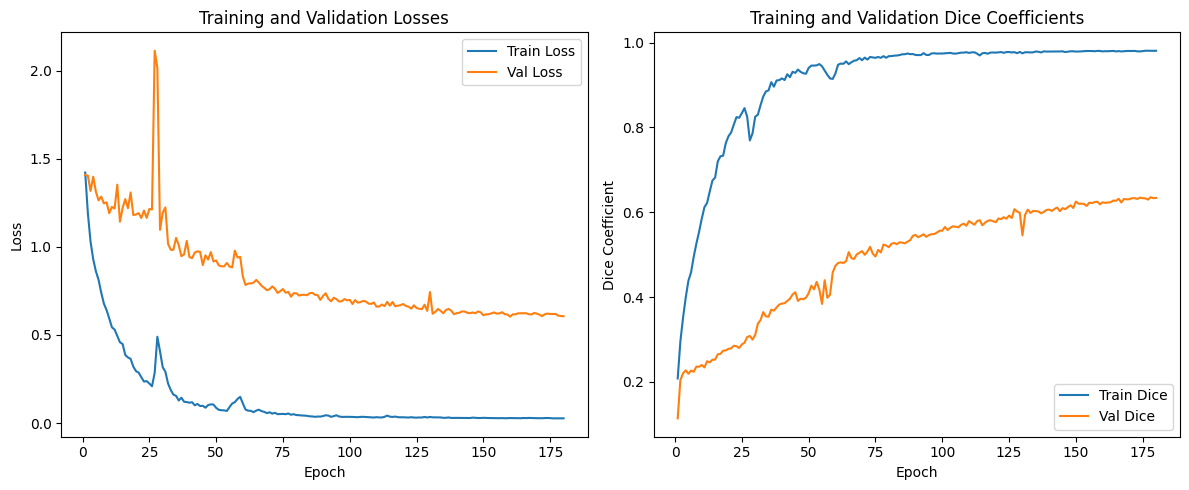

In [20]:
def to_numpy(tensor):
    # Move tensor to CPU and convert to NumPy array
    return tensor.cpu().detach().item()

def plot_metrics(metrics):
    num_epochs = len(metrics['train_losses'])
    epochs = np.arange(1, num_epochs + 1)

    # Convert tensors to NumPy arrays
    train_losses_np = metrics['train_losses']
    val_losses_np = metrics['val_losses']
    train_dices_np = [to_numpy(dice) for dice in metrics['train_dices']]
    val_dices_np = [to_numpy(dice) for dice in metrics['val_dices']]

    # Plot Losses
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses_np, label='Train Loss')
    plt.plot(epochs, val_losses_np, label='Val Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Dice Coefficients
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_dices_np, label='Train Dice')
    plt.plot(epochs, val_dices_np, label='Val Dice')
    plt.title('Training and Validation Dice Coefficients')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Coefficient')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(metrics)

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def to_numpy(tensor):
    # Move tensor to CPU and convert to NumPy array
    return tensor.cpu().detach().numpy()

def threshold_prediction(predicted, threshold=0.5):
    # Threshold predicted values
    predicted[predicted < threshold] = 0
    predicted[predicted >= threshold] = 1
    return predicted

def plot_subplots(image, mask, predicted, threshold=0.5):
    # Convert tensors to NumPy arrays
    image_np, mask_np, predicted_np = map(to_numpy, (image, mask, predicted))

    # Threshold the predicted values
    predicted_np_thresholded = threshold_prediction(predicted_np, threshold)

    fig, axes = plt.subplots(1, 3, figsize=(10, 5))  # Adjust figsize as needed

    # Plot Image, Mask, Predicted, and Thresholded Predicted
    titles = ['Image', 'Mask', 'Predicted']
    for ax, data, title in zip(axes, [image_np, mask_np, predicted_np, predicted_np_thresholded], titles):
        ax.imshow(data.squeeze(), cmap='gray' if 'Mask' in title else 'gray')
        ax.set_title(title)
        ax.axis('off')

    plt.show()

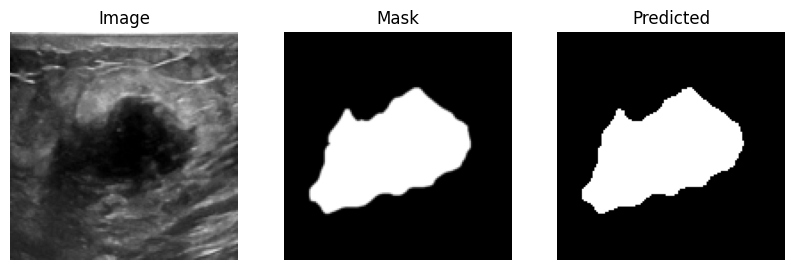

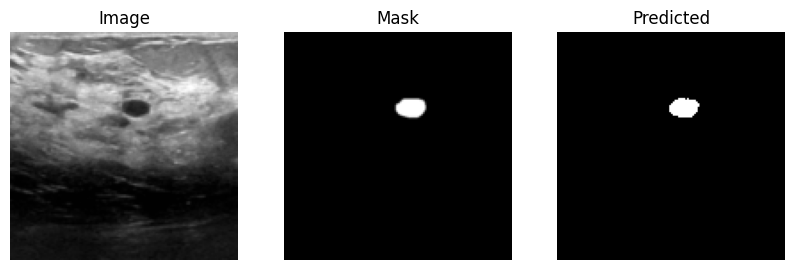

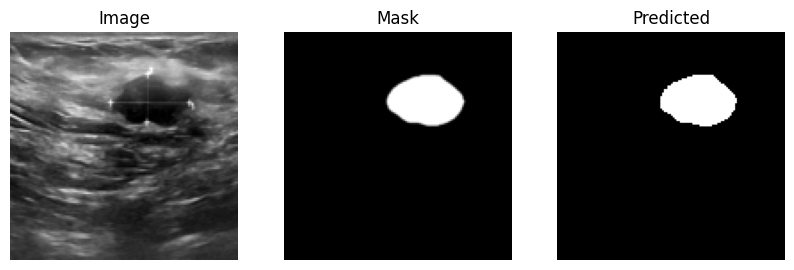

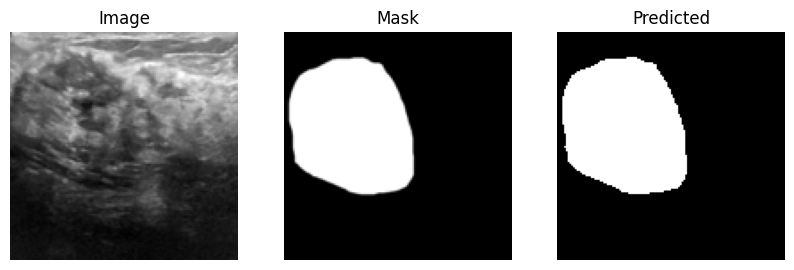

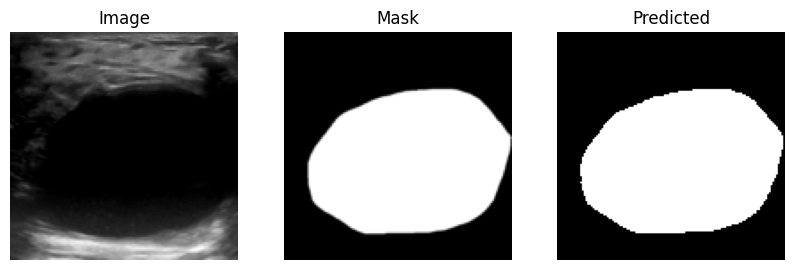

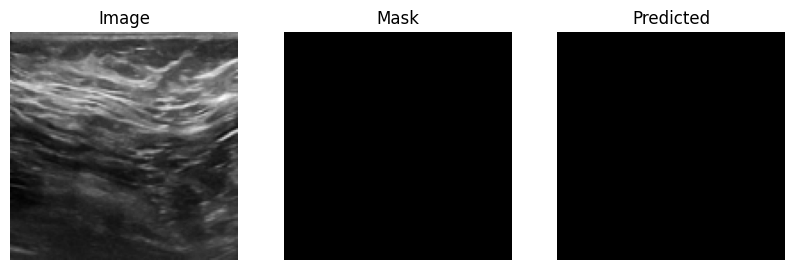

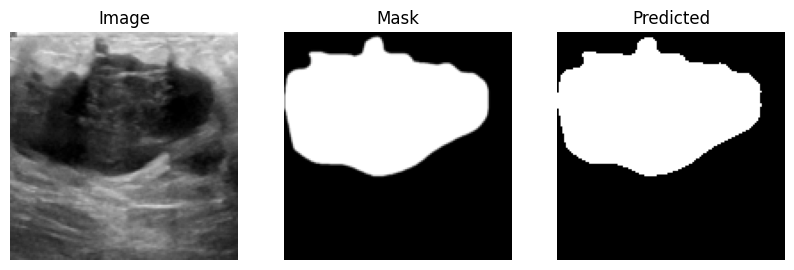

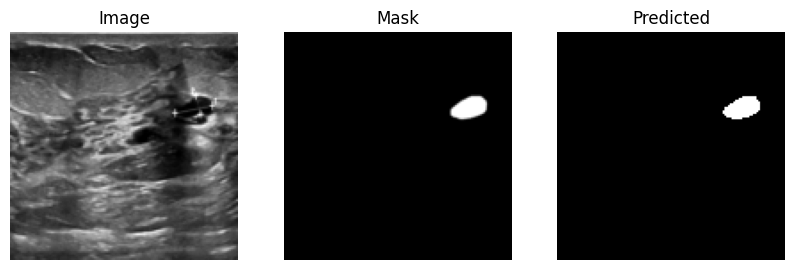

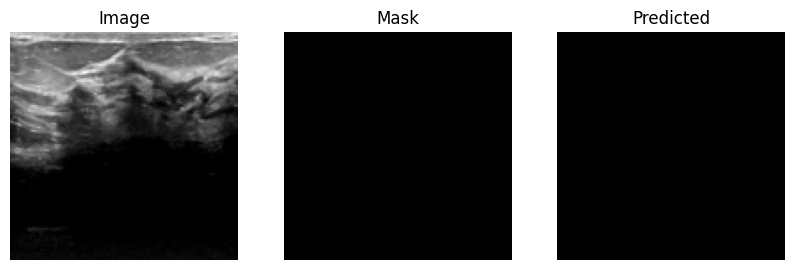

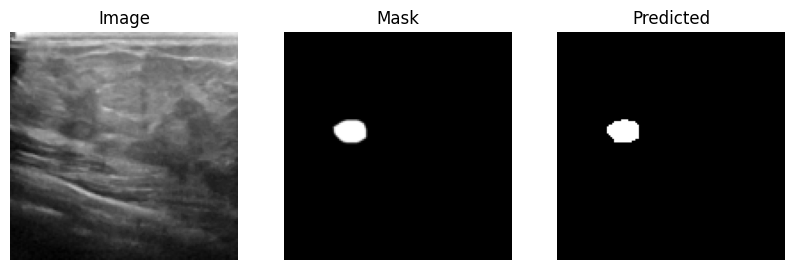

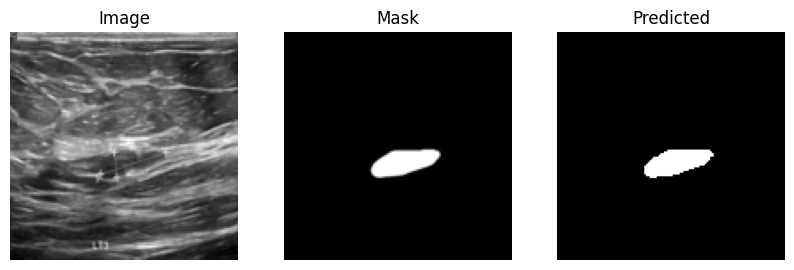

In [22]:
for i in [2, 3, 11, 20, 55, 67, 87, 98, 120, 130, 200]:
    image = train_dataset[i][0]
    mask = train_dataset[i][1]
    im = image.to(device)
    pred = unet(im.unsqueeze(0))
    pred = pred.squeeze()

    plot_subplots(im, mask, pred)